In [8]:
%autoreload 2

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspologic.align import OrthogonalProcrustes
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sample_edges
from pkg.inference import difference_norm
from pkg.plot import heatmap

In [3]:
def compute_diff_mats(X, Y, d=2):
    X_hat = AdjacencySpectralEmbed(n_components=d, check_lcc=False).fit_transform(X)
    Y_hat = AdjacencySpectralEmbed(n_components=d, check_lcc=False).fit_transform(Y)

    exact = difference_norm(X_hat, Y_hat, "exact")
    exact = exact @ exact.T
    global_ = difference_norm(X_hat, Y_hat, "global")
    global_ = global_ @ global_.T
    vertex = difference_norm(X_hat, Y_hat, "vertex")
    vertex = vertex @ vertex.T

    idx = np.diag_indices_from(exact)
    exact[idx] = 0
    global_[idx] = 0
    vertex[idx] = 0

    return exact, global_, vertex

In [4]:
def simulate(
    scale,
    reps=50,
):

    n = 25
    ns = [n, n]
    node_labels = ["Left"] * n + ["Right"] * n
    u = np.array(
        [
            [1 / 4, 3 / 4],
            [3 / 4, 1 / 4],
        ]
    )
    X = np.tile(u, n).reshape(-1, 2)

    w = np.array(
        [
            [0, 3 / 5],
            [3 / 5, 3 / 5],
        ]
    )
    Y = np.tile(w, n).reshape(-1, 2)

    res = []

    norms = []

    for i in range(reps):
        np.random.seed(i)

        if scale == "exact":
            P1 = X @ X.T
            P2 = X @ X.T
        elif scale == "global":
            P1 = X @ X.T
            P2 = X @ X.T * 1.5
        elif scale == "vertex":
            degree_correction = np.diag(np.tile(np.linspace(0.5, 1, n), 2))
            P1 = X @ X.T
            P2 = degree_correction @ X @ X.T @ degree_correction
        elif scale == "different":
            degree_correction = np.diag(np.tile(np.linspace(0.5, 1, n), 2)[::-1])
            P1 = degree_correction @ X @ X.T @ degree_correction

            degree_correction = np.random.uniform(0.75, 1, size=n * 2)
            degree_correction[:n] = np.sort(degree_correction[:n])
            degree_correction[n:] = np.sort(degree_correction[n:])
            degree_correction = np.diag(degree_correction)
            P2 = degree_correction @ Y @ Y.T @ degree_correction

        A = sample_edges(P1)
        B = sample_edges(P2)

        C, D, E = compute_diff_mats(A, B)

        res.append([A, B, C, D, E])
        norms.append([np.linalg.norm(C), np.linalg.norm(D), np.linalg.norm(E)])

    return np.array(res).mean(axis=0), np.array(norms).mean(axis=0)

In [5]:
out = [simulate(i) for i in ["exact", "global", "vertex", "different"]]

res = np.array([out[i][0] for i in range(4)])
norms = np.array([out[i][1] for i in range(4)])

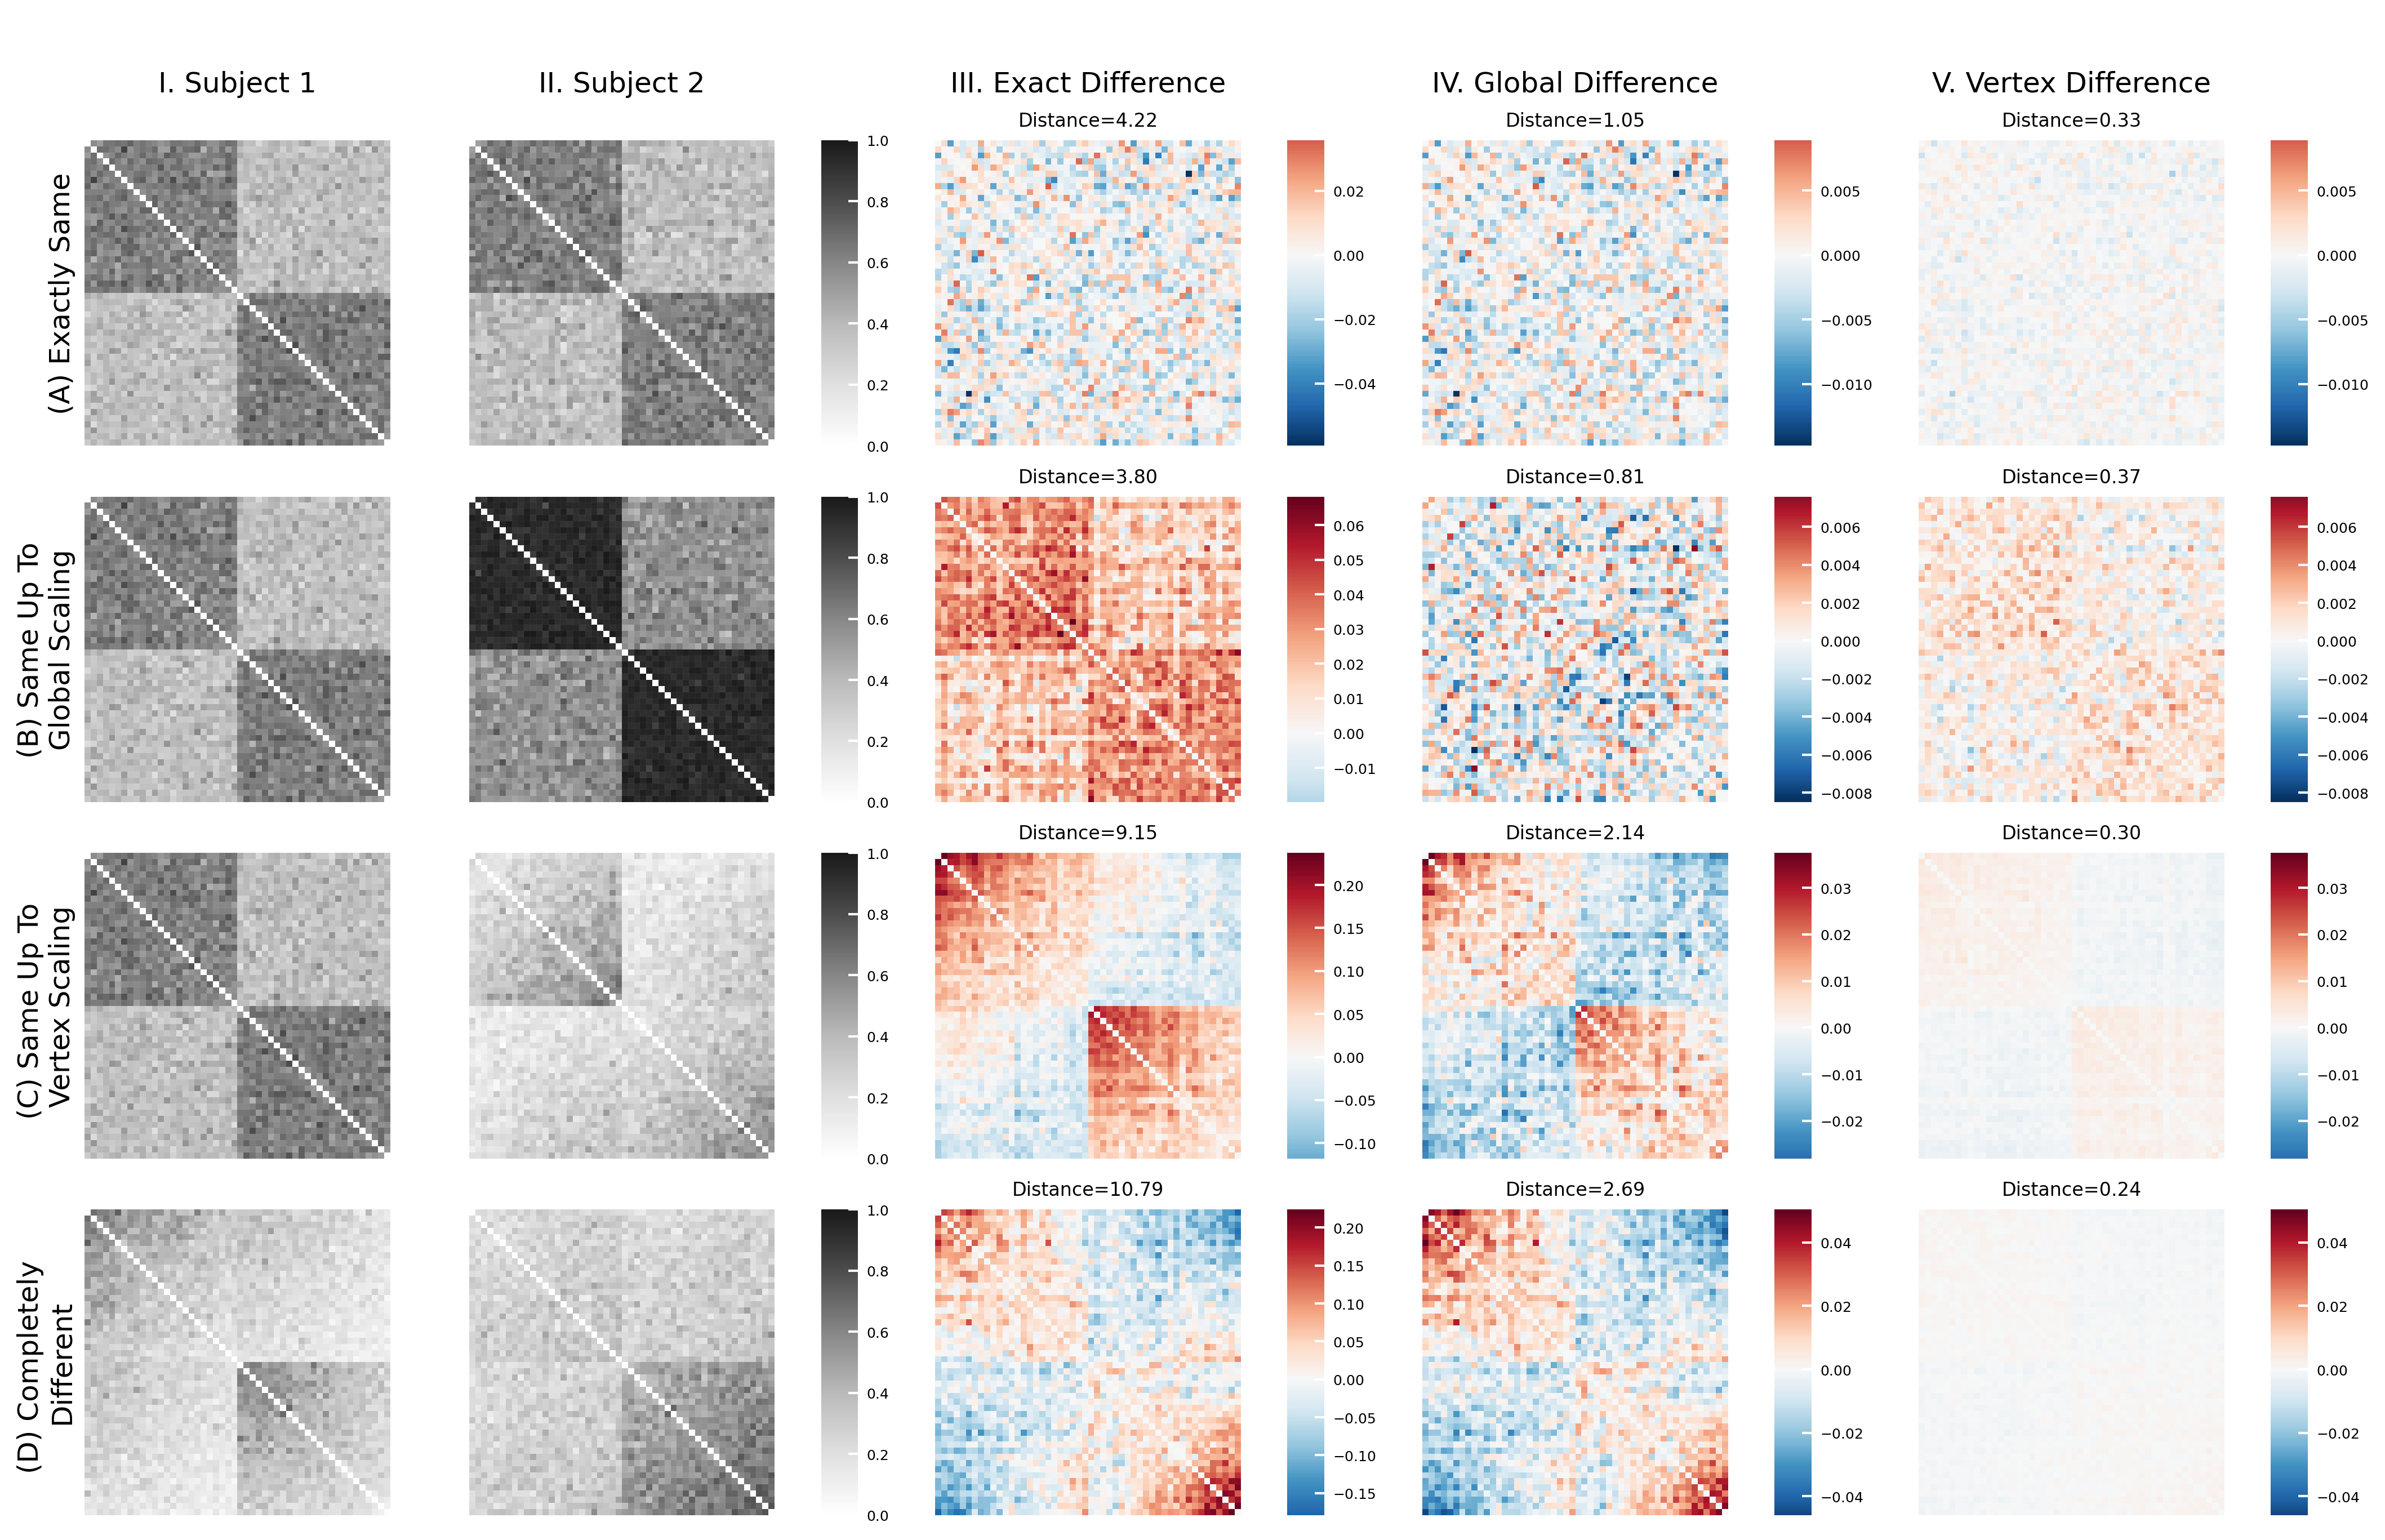

In [10]:
sns.set_context("talk", font_scale=0.5)

fig, ax = plt.subplots(
    nrows=5,
    ncols=9,
    figsize=(14, 9),
    dpi=300,
    height_ratios=[0.05, 1, 1, 1, 1],
    width_ratios=[1, 1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1],
    constrained_layout=True,
)

# plot average networks
to_plot = res[:, :2]
to_ax = ax[1:, :3]

for rdx, row in enumerate(to_plot):
    vmin = np.min(row)
    vmax = np.max(row)
    for cdx, col in enumerate(row):
        if cdx == 0:
            heatmap_kwargs = dict(
                vmin=0,
                vmax=1,
                cbar=False,
                # cbar_ax=to_ax[rdx, -1],
                cmap="RdGy",
            )
        else:
            heatmap_kwargs = dict(
                vmin=0,
                vmax=1,
                cbar=True,
                cbar_ax=to_ax[rdx, -1],
                cmap="RdGy",
            )

        heatmap(
            col,
            ax=to_ax[rdx, cdx],
            # axes_labels=node_labels,
            heatmap_kwargs=heatmap_kwargs,
        )

    cbar = to_ax[rdx, -1]
    # cbar.set_ylabel(
    #     "Edge Weight",
    # )
    # cbar.set_yticks([0, 0.5, 1], ["0", "0.5", "1"])
    cbar.tick_params(direction="in", length=4, width=1, color="w", labelsize=6)

# plot diffs
to_plot = res[:, 2:]
to_ax = ax[1:, 3:]

heatmap_idx = [0, 2, 4]
cbar_idx = [1, 3, 5]

for rdx, row in enumerate(to_plot):
    vmin1 = np.min(row[0])
    vmax1 = np.max(row[0])

    vmin2 = np.min(row[1])
    vmax2 = np.max(row[1])

    for cdx, col in enumerate(row):
        if cdx == 0:
            vmin = vmin1
            vmax = vmax1
        else:
            vmin = vmin2
            vmax = vmax2
        heatmap(
            col,
            ax=to_ax[rdx, heatmap_idx[cdx]],
            # axes_labels=node_labels,
            heatmap_kwargs=dict(
                vmin=vmin,
                vmax=vmax,
                cbar=True,
                cbar_ax=to_ax[rdx, cbar_idx[cdx]],
                cmap="RdBu_r",
            ),
        )
        cbar = to_ax[rdx, cbar_idx[cdx]]
        cbar.tick_params(direction="in", length=4, width=1, color="w", labelsize=6)
        # cbar.ticklabel_format(useMathText=True)
        cbar.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True))
        val = np.linalg.norm(col)
        to_ax[rdx, heatmap_idx[cdx]].set_title(
            f"Distance={norms[rdx, cdx]:.2f}", fontdict=dict(fontsize=8)
        )

for a in ax[0]:
    sns.despine(ax=a, left=True, bottom=True)
    a.tick_params(axis="both", which="both", bottom=False, left=False, top=False)
    a.set_yticklabels("")
    a.set_xticklabels("")

to_ax = ax[0]
y_titles = [
    "I. Subject 1",
    "II. Subject 2",
    "III. Exact Difference",
    "IV. Global Difference",
    "V. Vertex Difference",
]

for idx, col in enumerate([0, 1, 3, 5, 7]):
    to_ax[col].set_xlabel(
        y_titles[idx],
        fontdict=dict(fontsize=12),
    )

to_ax = ax[1:, 0]
x_titles = [
    "(A) Exactly Same",
    "(B) Same Up To\nGlobal Scaling",
    "(C) Same Up To \nVertex Scaling",
    "(D) Completely \nDifferent",
]

for idx, row in enumerate(range(4)):
    to_ax[row].set_ylabel(
        x_titles[row],
        fontdict=dict(fontsize=12),
    )

In [11]:
fig.savefig("./figures/3-simulations.pdf", bbox_inches="tight")